In [1]:
import numpy as np
import scipy as sp
import json
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.misc import imresize
import tensorflow.keras as keras
from tensorflow.keras.models import load_model

# Load model

In [2]:
model1 = load_model('model1.h5')
input_shape = (32, 24, 1)

# Image

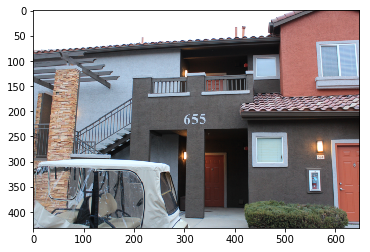

In [3]:
filepath = 'input/12.JPG'
frac = .25
orig_img = Image.open(filepath)
orig_img = orig_img.resize((int(orig_img.size[0]*frac), int(orig_img.size[1]*frac)), Image.BILINEAR)
plt.imshow(orig_img)

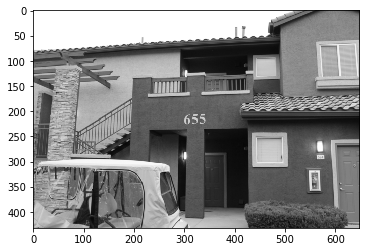

In [4]:
gray_img = (orig_img.convert('L'))
plt.imshow(gray_img, cmap='gray')

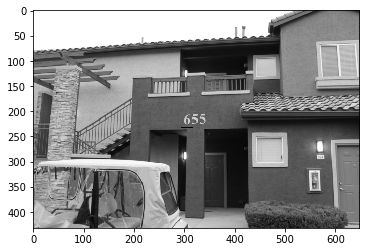

In [5]:
img_copy = gray_img.copy()
draw = ImageDraw.Draw(img_copy)
x, y = 293, 200
draw.rectangle([x, y, x+24, y+32])
del draw
plt.imshow(img_copy, cmap='gray')

In [6]:
img = np.array(gray_img)

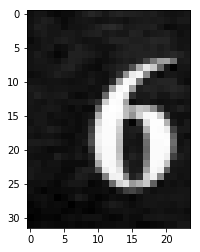

In [7]:
x, y = 290, 200
h = input_shape[0]
w = input_shape[1]
cut = img[y:y+h, x:x+w]
plt.imshow(cut, cmap='gray')

In [8]:
def classify_cut(cut, model=model1):
    sample = cut.astype(np.float32) / np.max(cut)
    sample = sample.reshape((1, *input_shape))
    
    pred = model.predict(sample)
    label = pred.argmax(axis=1)[0]
    p = np.max(pred)
    
    return label, p

In [9]:
boxes = []
h = input_shape[0]
w = input_shape[1]
for y in range(0, img.shape[0]-h, 8):
    for x in range(0, img.shape[1]-w, 8):
        cut = img[y:y+h, x:x+w]
        label, p = classify_cut(cut)
        if label != 10 and p > .98:
            boxes.append({
                'x': x, 'y': y,
                'w': w, 'h': h,
                'label': label,
                'p': p
            })
boxes

[{'x': 384, 'y': 128, 'w': 24, 'h': 32, 'label': 1, 'p': 0.98467326},
 {'x': 392, 'y': 128, 'w': 24, 'h': 32, 'label': 1, 'p': 0.98489225},
 {'x': 224, 'y': 136, 'w': 24, 'h': 32, 'label': 1, 'p': 0.98518664},
 {'x': 256, 'y': 136, 'w': 24, 'h': 32, 'label': 1, 'p': 0.9865616},
 {'x': 264, 'y': 136, 'w': 24, 'h': 32, 'label': 1, 'p': 0.9878066},
 {'x': 272, 'y': 136, 'w': 24, 'h': 32, 'label': 1, 'p': 0.98466486},
 {'x': 280, 'y': 136, 'w': 24, 'h': 32, 'label': 1, 'p': 0.9992023},
 {'x': 184, 'y': 176, 'w': 24, 'h': 32, 'label': 7, 'p': 0.98733807},
 {'x': 408, 'y': 176, 'w': 24, 'h': 32, 'label': 2, 'p': 0.99967325},
 {'x': 136, 'y': 192, 'w': 24, 'h': 32, 'label': 4, 'p': 0.9809873},
 {'x': 168, 'y': 200, 'w': 24, 'h': 32, 'label': 1, 'p': 0.99671125},
 {'x': 288, 'y': 200, 'w': 24, 'h': 32, 'label': 6, 'p': 0.9912116},
 {'x': 296, 'y': 200, 'w': 24, 'h': 32, 'label': 6, 'p': 0.99967563},
 {'x': 304, 'y': 200, 'w': 24, 'h': 32, 'label': 5, 'p': 0.99997246},
 {'x': 312, 'y': 200, 'w'

In [10]:
len(boxes)

30

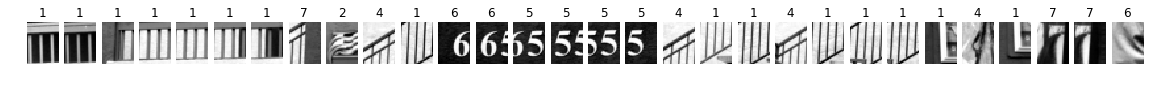

In [11]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=30)

for i in range(30):
    x = boxes[i]['x']
    y = boxes[i]['y']
    w = boxes[i]['w']
    h = boxes[i]['h']
    label = boxes[i]['label']
    cut = img[y:y+h, x:x+w]
    
    ax[i].axis('off')
    ax[i].imshow(cut, cmap='gray')
    ax[i].set_title(label, loc='center')

In [12]:
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return boxes
    
    pick = []
    
    x1 = np.array([box['x'] for box in boxes])
    y1 = np.array([box['y'] for box in boxes])
    x2 = np.array([box['x'] + box['w'] for box in boxes])
    y2 = np.array([box['y'] + box['h'] for box in boxes])
    p = np.array([box['p'] for box in boxes])
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(p)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        for pos in range(0, last):
            j = idxs[pos]
 
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
 
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
 
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
 
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
 
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
 
    # return only the bounding boxes that were picked
    suppressed_boxes = [boxes[idx] for idx in np.sort(pick)]
    return suppressed_boxes

In [13]:
suppressed_boxes = non_max_suppression(boxes, 0.5)
suppressed_boxes

[{'x': 392, 'y': 128, 'w': 24, 'h': 32, 'label': 1, 'p': 0.98489225},
 {'x': 224, 'y': 136, 'w': 24, 'h': 32, 'label': 1, 'p': 0.98518664},
 {'x': 264, 'y': 136, 'w': 24, 'h': 32, 'label': 1, 'p': 0.9878066},
 {'x': 280, 'y': 136, 'w': 24, 'h': 32, 'label': 1, 'p': 0.9992023},
 {'x': 184, 'y': 176, 'w': 24, 'h': 32, 'label': 7, 'p': 0.98733807},
 {'x': 408, 'y': 176, 'w': 24, 'h': 32, 'label': 2, 'p': 0.99967325},
 {'x': 136, 'y': 192, 'w': 24, 'h': 32, 'label': 4, 'p': 0.9809873},
 {'x': 168, 'y': 200, 'w': 24, 'h': 32, 'label': 1, 'p': 0.99671125},
 {'x': 288, 'y': 200, 'w': 24, 'h': 32, 'label': 6, 'p': 0.9912116},
 {'x': 304, 'y': 200, 'w': 24, 'h': 32, 'label': 5, 'p': 0.99997246},
 {'x': 320, 'y': 200, 'w': 24, 'h': 32, 'label': 5, 'p': 0.9999968},
 {'x': 112, 'y': 208, 'w': 24, 'h': 32, 'label': 4, 'p': 0.98295194},
 {'x': 144, 'y': 216, 'w': 24, 'h': 32, 'label': 1, 'p': 0.99923766},
 {'x': 88, 'y': 224, 'w': 24, 'h': 32, 'label': 4, 'p': 0.9965397},
 {'x': 112, 'y': 232, 'w': 

In [14]:
len(suppressed_boxes)

19

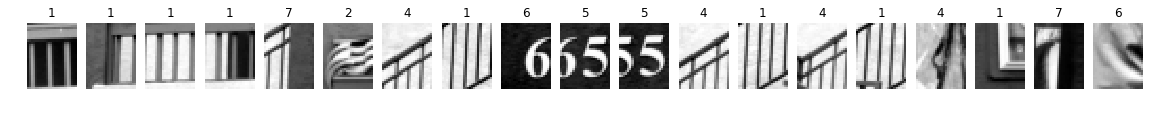

In [15]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=19)

for i in range(19):
    x = suppressed_boxes[i]['x']
    y = suppressed_boxes[i]['y']
    w = suppressed_boxes[i]['w']
    h = suppressed_boxes[i]['h']
    label = suppressed_boxes[i]['label']
    cut = img[y:y+h, x:x+w]
    
    ax[i].axis('off')
    ax[i].imshow(cut, cmap='gray')
    ax[i].set_title(label, loc='center')

In [16]:
def euc_dist(box1, box2):
    return ((box1['x'] - box2['x'])**2 + (box1['y'] - box2['y'])**2) ** .5

In [17]:
ps = np.array([box['p'] for box in suppressed_boxes])
idx_max = ps.argmax()
box_max = suppressed_boxes[idx_max]
thresh = (box_max['w'] ** 2 + box_max['h'] ** 2) ** .5
sign_boxes = [box_max]
for i in range(len(suppressed_boxes)):
    if i == idx_max:
        continue
        
    if euc_dist(box_max, suppressed_boxes[i]) < thresh:
        sign_boxes.append(suppressed_boxes[i])

xs = np.array([box['x'] for box in sign_boxes])
idxs = np.argsort(xs)
sign_boxes = [sign_boxes[idx] for idx in idxs]
sign_boxes

[{'x': 288, 'y': 200, 'w': 24, 'h': 32, 'label': 6, 'p': 0.9912116},
 {'x': 304, 'y': 200, 'w': 24, 'h': 32, 'label': 5, 'p': 0.99997246},
 {'x': 320, 'y': 200, 'w': 24, 'h': 32, 'label': 5, 'p': 0.9999968}]

In [18]:
sign = ''.join([str(box['label']) for box in sign_boxes])
sign

'655'